<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

В нашем распоряжении исторические данные о заказах такси в аэропортах. Чтобы привлекать достаточное число водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  

**Описание данных:**
`num_orders` - количество заказов

## Подготовка

Импортируем пакеты

In [29]:
import os
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

Первичный анализ данных

In [30]:
BASE_DIR = os.getcwd()
df = pd.read_csv(f'{BASE_DIR}/datasets/taxi.csv')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [32]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Проверяем дубликаты

In [33]:
df['datetime'].duplicated().sum()

0

Меняем тип данных да datetime

In [34]:
df['datetime'] = pd.to_datetime(df['datetime'])

Назначаем datetime в качестве индекса

In [35]:
df = df.set_index(df['datetime'])
df = df.drop('datetime', axis=1)

Проверяем последовательны ли значения индексов

In [36]:
print(df.index.is_monotonic_increasing)

True


Ресемлируем на один час, в качестве аггрегируеющей функции используем mean

In [37]:
df = df.resample('1h').sum()

Облегчим данные

In [38]:
df['num_orders'] = pd.to_numeric(df['num_orders'], downcast='integer')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 43.1 KB


In [40]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Был изменён тип данных столбца datetime  
Даты назначены в качестве индексов  
Проведены проверка на дубликаты и сортировку дат  
Данные ресемплированы по одному часу  
Тип данных столбца `num_orders` изменён на более лёгкий  

## Анализ

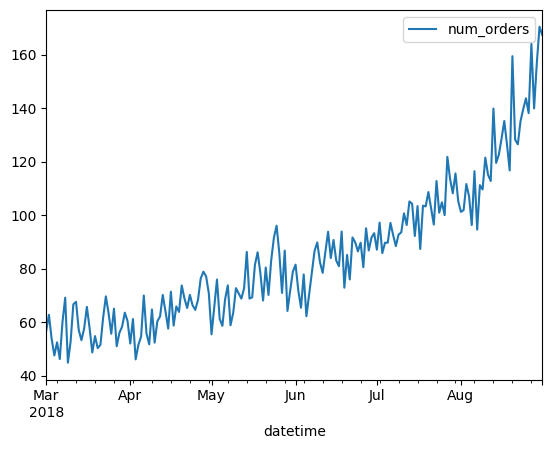

In [41]:
df.resample('1D').mean().plot(kind='line');

В данных явно прослеживается определённый тренд, попробуем разложить ряд с помощью seasona_decompose

Выделим тренд

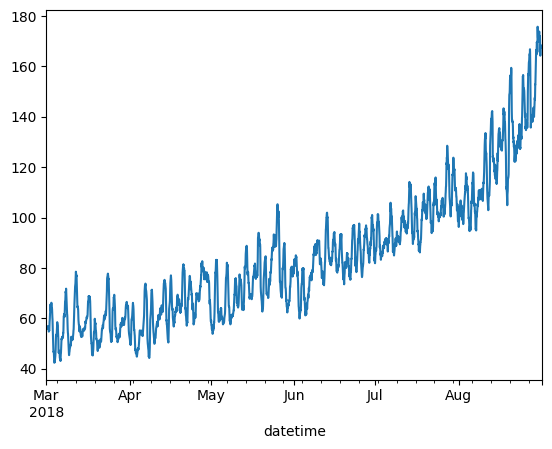

In [42]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot();

Выделим сезонность

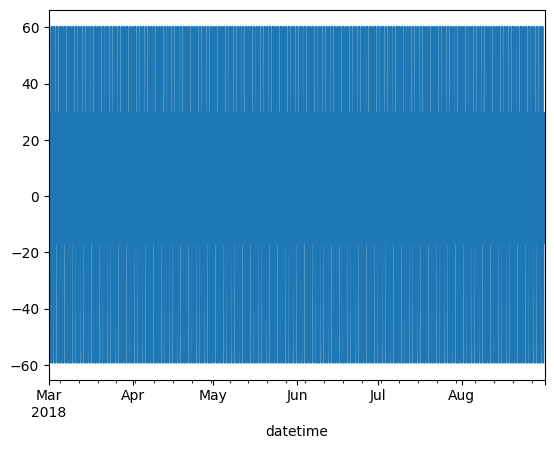

In [43]:
decomposed.seasonal.plot();

На текущем масштабе сложно оценить сезонность, посмотрим на более мелком, но прежде оценим остаток

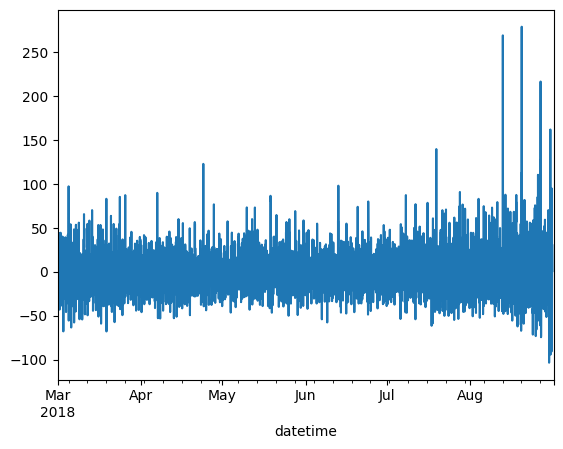

In [44]:
decomposed.resid.plot();

Посмотрим сезонность на более мелком таймфрейме

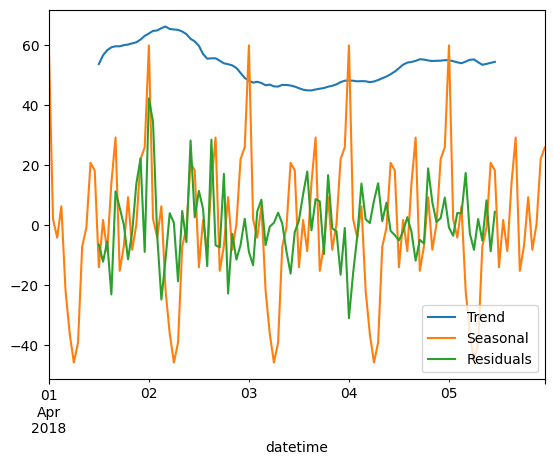

In [45]:
decomposed = seasonal_decompose(df['2018-04-01':'2018-04-5'])
decomposed.trend.plot(label='Trend')
decomposed.seasonal.plot(label='Seasonal')
decomposed.resid.plot(label='Residuals')

plt.legend()
plt.show();

На графике мы видим повторяющийся паттерн из пяти одинаковых фигур, что соответствует количеству отображаемых на графике дней. Как и предполагалось в данных есть суточный цикл.

Были вывлены две составляющих ряда, тренд и суточная сезонность.  

## Обучение модели

Создание признаков

Добавим новые признаки дней недели, дней месяца и часа

In [46]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['day_of_month'] = df.index.day

Создадим функцию для подбора параметров скользящего среднего и запаздывающих значений.

In [47]:
def transform(X, y, lag_n, ma_n):
    new_X = X.copy()
    new_y = y.copy()
    for i in range(1, lag_n+1):
        new_X[f'lag_{i}'] = new_X['num_orders'].shift(i)
    for i in range(1, ma_n+1):
        new_X[f'moving_average_{i}'] = new_X['num_orders'].shift().rolling(i).mean()
    new_X = new_X.drop('num_orders', axis=1)
    new_X = new_X.dropna()
    new_y = y.tail(new_X.shape[0])
    return new_X, new_y

Разделяем выборку

In [48]:
target = df['num_orders']
features = df
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Создадим объект кросс-валидации на временных рядах.

In [49]:
tss = TimeSeriesSplit(n_splits=8)

### Linear Regression

In [50]:
parameters = []

for i in range(1,40):
    for j in range(1,10):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])

        params = {}

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'RMSE' : (-grid.best_score_)**0.5,
        })

pd.DataFrame(parameters).sort_values('RMSE').head()

,lag_n,ma_n,RMSE
251,28,9,26.727780
249,28,7,26.728219
246,28,4,26.729133
243,28,1,26.730094
248,28,6,26.730765


Лучшие параметры LinearRegression:  
RMSE = 26.72  
lag_n = 28  
ma_n = 9  

### Decision Tree

In [51]:
parameters = []

for i in range(1,40):
    for j in range(1,10):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', DecisionTreeRegressor())
        ])

        params = {
            'regressor__max_depth': range(1,20)
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

pd.DataFrame(parameters).sort_values('RMSE').head()

,lag_n,ma_n,estimator_params,RMSE
17,2,9,{'regressor__max_depth': 7},28.250069
151,17,8,{'regressor__max_depth': 7},28.350180
16,2,8,{'regressor__max_depth': 7},28.360661
145,17,2,{'regressor__max_depth': 8},28.399427
143,16,9,{'regressor__max_depth': 7},28.416515


Лучшие параметры DecisionTreeRegressor:   
RMSE = 28.18  
max_depth = 7  
lag_n = 17  
ma_n = 9  

### Random Forest

In [52]:
parameters = []

for i in range(34,37,1):
    for j in range(18,23,1):
        X_train, y_train = transform(features_train, target_train, i, j)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', RandomForestRegressor())
        ])

        params = {
            'regressor__max_depth': range(20,25,1),
            'regressor__n_estimators': range(200,240,10),
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

        print(parameters[-1])

pd.DataFrame(parameters).sort_values('RMSE').head()

{'lag_n': 34, 'ma_n': 18, 'estimator_params': {'regressor__max_depth': 24, 'regressor__n_estimators': 210}, 'RMSE': 24.49239565536454}
{'lag_n': 34, 'ma_n': 19, 'estimator_params': {'regressor__max_depth': 22, 'regressor__n_estimators': 200}, 'RMSE': 24.45274995174371}
{'lag_n': 34, 'ma_n': 20, 'estimator_params': {'regressor__max_depth': 20, 'regressor__n_estimators': 210}, 'RMSE': 24.487278285143866}
{'lag_n': 34, 'ma_n': 21, 'estimator_params': {'regressor__max_depth': 24, 'regressor__n_estimators': 200}, 'RMSE': 24.506157787802593}
{'lag_n': 34, 'ma_n': 22, 'estimator_params': {'regressor__max_depth': 20, 'regressor__n_estimators': 220}, 'RMSE': 24.489281824917075}
{'lag_n': 35, 'ma_n': 18, 'estimator_params': {'regressor__max_depth': 22, 'regressor__n_estimators': 220}, 'RMSE': 24.4645392229907}
{'lag_n': 35, 'ma_n': 19, 'estimator_params': {'regressor__max_depth': 23, 'regressor__n_estimators': 220}, 'RMSE': 24.490751799531186}
{'lag_n': 35, 'ma_n': 20, 'estimator_params': {'regr

,lag_n,ma_n,estimator_params,RMSE
1,34,19,"{'regressor__max_depth': 22, 'regressor__n_est...",24.452750
5,35,18,"{'regressor__max_depth': 22, 'regressor__n_est...",24.464539
7,35,20,"{'regressor__max_depth': 20, 'regressor__n_est...",24.467453
11,36,19,"{'regressor__max_depth': 23, 'regressor__n_est...",24.472874
10,36,18,"{'regressor__max_depth': 23, 'regressor__n_est...",24.473291


Лучшие параметры RandomForestRegressor:   
RMSE = 24.45  
max_depth = 22  
n_estimators = 210  
lag_n = 34  
ma_n = 19  

### CatBoost

In [60]:
parameters = []

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', CatBoostRegressor(
        loss_function='RMSE', 
        random_seed=1, 
        iterations=2000,  
        verbose=250,
    ))
])

for i in [27]:
    for j in [1]:
        X_train, y_train = transform(features_train, target_train, i, j)

        params = {
            'regressor__depth': [5],
        }

        grid = GridSearchCV(
            pipe,
            param_grid=params, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            cv=tss,
        )

        grid.fit(X_train, y_train)

        parameters.append({
            'lag_n' : i,
            'ma_n' : j,
            'estimator_params' : grid.best_params_,
            'RMSE' : (-grid.best_score_)**0.5,
        })

        print(parameters[-1])

pd.DataFrame(parameters).sort_values('RMSE').head()

Learning rate set to 0.02895
0:	learn: 38.1656093	total: 6.13ms	remaining: 12.3s
250:	learn: 21.5765414	total: 936ms	remaining: 6.52s
500:	learn: 19.1008353	total: 1.78s	remaining: 5.33s
750:	learn: 17.1908062	total: 2.62s	remaining: 4.36s
1000:	learn: 15.7949972	total: 3.44s	remaining: 3.44s
1250:	learn: 14.6069144	total: 4.28s	remaining: 2.56s
1500:	learn: 13.6109477	total: 5.15s	remaining: 1.71s
1750:	learn: 12.7574274	total: 6.05s	remaining: 861ms
1999:	learn: 11.9749933	total: 7.04s	remaining: 0us
{'lag_n': 27, 'ma_n': 1, 'estimator_params': {'regressor__depth': 5}, 'RMSE': 23.76898100172804}


,lag_n,ma_n,estimator_params,RMSE
0,27,1,{'regressor__depth': 5},23.768981


Лучший результат CatBoostRegressor:  
RMSE = 23.76  
iterations = 2000  
lag_n = 27  
ma_n = 1  
depth = 5  

На данных были обучены четыре модели: линейная регрессия, решающее дерево, случайный лес, градиентный бустинг.  
Лучший результат RMSE = 23.76 показала модель CatBoostRegressor. На следующем этапе проверим её работу на тестовой выборке.

## Тестирование

In [61]:
X_train, y_train = transform(features_train, target_train, 7, 9)
X_test, y_test = transform(features_test, target_test, 7, 9)

grid.best_estimator_.fit(X_train, y_train)
prediction = grid.best_estimator_.predict(X_test)

Learning rate set to 0.028971
0:	learn: 38.1488862	total: 4.78ms	remaining: 9.55s
250:	learn: 22.8609538	total: 705ms	remaining: 4.91s
500:	learn: 20.5709363	total: 1.34s	remaining: 4s
750:	learn: 18.8963359	total: 1.98s	remaining: 3.3s
1000:	learn: 17.7902013	total: 2.61s	remaining: 2.6s
1250:	learn: 16.9576719	total: 3.24s	remaining: 1.94s
1500:	learn: 16.2027459	total: 3.85s	remaining: 1.28s
1750:	learn: 15.4988804	total: 4.48s	remaining: 637ms
1999:	learn: 14.8633936	total: 5.11s	remaining: 0us


In [62]:
print(mean_squared_error(y_test, prediction)**0.5)

46.00068269902999


RMSE на тестовой выборке 46, что соответствует условию поставленной задачи.

Тестом тестом Дики-Фуллера проверим остатки на стационарность

In [63]:
pred_df = pd.DataFrame(prediction).set_index(y_test.index)[0]
residuals = pred_df - y_test

In [64]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(residuals)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -21.949875633066014
p-value: 0.0
Critical Values: {'1%': -3.445578199334947, '5%': -2.8682536932290876, '10%': -2.570346162765775}


P-value 0.0, следовательно ряд стационарный.  
Проанализируем визуально.

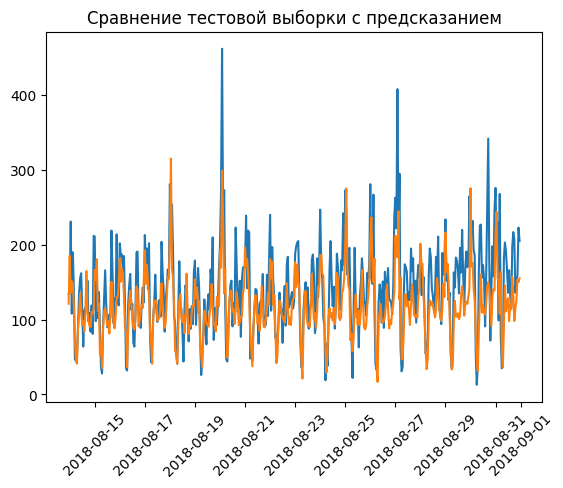

In [65]:
import matplotlib.pyplot as plt

plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, prediction, label='Predicted')
plt.xticks(rotation=45)
plt.title('Сравнение тестовой выборки с предсказанием')
plt.show()


<AxesSubplot:xlabel='datetime'>

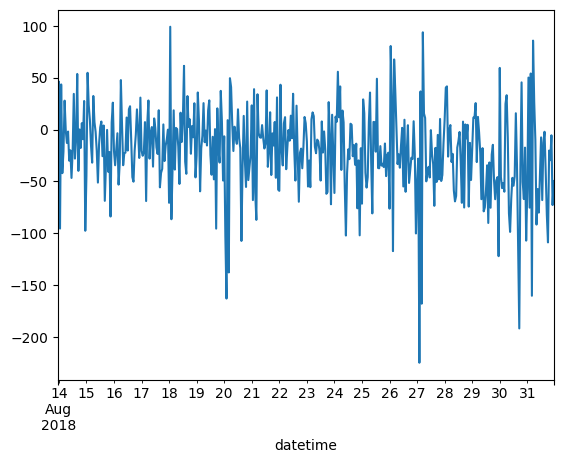

In [66]:
residuals.plot(kind='line')

Визуально мы не можем выделить закономерности в остатках, следовательно модель обучена корректно и может быть рекомендована для дальнейшего использования.

## Вывод

Были обучены четыре модели: линейная регрессия, решающее дерево, случайный лес, градиентный бустинг.  
Лучший результат на кросс-валидации - `RMSE = 23.76` показала модель `CatBoostRegressor`. На тестовой выборке `RMSE = 46`.  
Остатки прошли тест Дики-Фуллера на проверку стационарности.